In [2]:
import math
import os
import random
import utils
import config

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import preprocessing

# For ARIMA model
import pmdarima as pm
import joblib
import pickle

# For RNN & LSTM model
import tensorflow as tf
from tensorflow import keras
from keras import Model, initializers
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

# For GCN-LSTM model
import stellargraph as sg
from stellargraph.layer import GCN_LSTM

# Evaluation metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

%matplotlib inline

In [3]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [4]:
def eval_ARIMA():
    saltlake_week = pd.read_csv('../Data/saltlake_week.csv')
    
    y = saltlake_week[['Day', 'VMT (Veh-Miles)']].iloc[53:, :]
    y.columns = ['Week', 'VMT']
    y['Week'] = pd.to_datetime(y['Week'])
    
    y.set_index('Week', inplace=True)

    X = saltlake_week[['Day', 'Cases', 'News Sentiment', 'Unemployment Rate', 'PRCP', 'SNWD',
                             'Percent_Fully_Vaccinated_5&Older', 'TAVG',
                             'Stay at Home', 'Mask', 'School Opening', 'Health Emergency', 'Holiday']].iloc[53:209, :]
    X.columns = ['Week', 'Cases', 'News Sentiment', 'Unemployment Rate', 'PRCP', 'SNWD',
                                 'Percent_Fully_Vaccinated_5&Older', 'TAVG',
                                 'Stay at Home', 'Mask', 'School Opening', 'Health Emergency', 'Holiday']

    X['Week'] = pd.to_datetime(X['Week'])
    X.set_index('Week', inplace=True)

    X_diff = X.diff().dropna()
    X_diff2 = X_diff.diff().dropna()

    y_scaler, y_scaled = utils.scale(y)
    y_scaled = pd.DataFrame(y_scaled, columns=['VMT'], index=y.index)

    trainX_diff2 = X_diff2.iloc[:146, :]
    testX_diff2 = X_diff2.iloc[146:, :]
    trainY = y_scaled.iloc[2:148, :]
    testY = y_scaled.iloc[148:, :]

    model = joblib.load('ARIMA/arima.pkl')

    y_pred = model.predict(n_periods = 4, X=testX_diff2)
    y_pred_inv = y_scaler.inverse_transform(y_pred.reshape((-1, 1)))

    prediction = pd.DataFrame(y_pred_inv,index=testY.index, columns=['VMT'])    
        
        
    trainY_inv = pd.DataFrame(y_scaler.inverse_transform(trainY), index=trainY.index, columns=['VMT']) 
    testY_inv = pd.DataFrame(y_scaler.inverse_transform(testY), index=testY.index, columns=['VMT'])
        # print(testY_inv.head())

    
    plt.figure(figsize=(8,5))
    plt.plot(trainY_inv,label="Training")
    plt.plot(testY_inv,label="Test")
    plt.plot(prediction,label="Predicted")
    plt.legend(loc = 'upper left')
    plt.show()
    
    testY_inv = pd.DataFrame(testY_inv)
    testY_inv['Predicted_VMT'] = prediction
    
    plt.figure(figsize=(8,5))
    plt.plot(testY_inv['VMT'],label="Test")
    plt.plot(prediction,label="Predicted")
    plt.title("ARIMA Predicted VMT")
    plt.legend(loc = 'upper left')
    plt.savefig('ARIMA/output/ARIMA-test-2.jpg')
    plt.show()

    print("R2 Score: {}".format(r2_score(testY_inv['VMT'], testY_inv['Predicted_VMT'])))
          
    mape = mean_absolute_percentage_error(testY_inv['VMT'], testY_inv['Predicted_VMT'])
    mse = mean_squared_error(testY_inv['VMT'], testY_inv['Predicted_VMT'])
    rmse = mean_squared_error(testY_inv['VMT'], testY_inv['Predicted_VMT'], squared=False)
          
    print("MAPE: {}".format(mape))
    print("MSE: {}".format(mse))
    print("RMSE: {}".format(rmse))
    
    return prediction.values

In [5]:
def format_scale_data_rnn(data, weeks=1):
    X_total = data.values

    data = X_total[(53-weeks):, :]
    print(data.shape)
    scaler, values = utils.scale(data)
    values = utils.series_to_supervised(values, n_in=weeks, n_out=1, dropnan=True).values

    y_scaler, y = utils.scale(data[:, 1].reshape((len(data), 1)))

    train = values[:140, :]
    valid1 = values[140:144, :]
    valid2 = values[144:148, :]
    test = values[148:, :]

    features = 13
    obs = weeks*features

    y = values[:, -features:]

    trainX = train[:, :obs]
    trainY = train[:, -features:][:, 1]
    validX1 = valid1[:, :obs]
    validY1 = valid1[:, -features:][:, 1]
    validX2 = valid2[:, :obs]
    validY2 = valid2[:, -features:][:, 1]
    testX = test[:, :obs]
    testY = test[:, -features:][:, 1]

    trainX = trainX.reshape((trainX.shape[0], weeks, features))
    validX1 = validX1.reshape((validX1.shape[0], weeks, features))
    validX2 = validX2.reshape((validX2.shape[0], weeks, features))
    testX = testX.reshape((testX.shape[0], weeks, features))
    
    print(trainX.shape, validX1.shape, validX2.shape, testX.shape)

    return trainX, trainY, validX1, validY1, validX2, validY2, testX, testY, scaler, y_scaler

In [6]:
def load_eval_model_rnn(name, w, output):
    model = load_model(name)
    print(model.summary())
    
    saltlake_week = pd.read_csv('../Data/saltlake_week.csv')
    data = saltlake_week[['Cases', 'VMT (Veh-Miles)', 'News Sentiment', 'Unemployment Rate', 'PRCP', 'SNWD',
                          'Percent_Fully_Vaccinated_5&Older', 'TAVG', 
                          'Stay at Home', 'Mask', 'School Opening', 'Health Emergency', 'Holiday']]
    trainX, trainY, validX1, validY1, validX2, validY2, testX, testY, scaler, y_scaler = format_scale_data_rnn(data=data, 
    
                                                                                                               weeks=w)
    
    y = data['VMT (Veh-Miles)']
    testY_inv = y.iloc[148:]

    testY_inv = testY_inv.reset_index()
    testY_inv.drop('index', axis=1, inplace=True)
    testY_inv = testY_inv.values
    
    print(model.evaluate(testX, testY))
    
    yhat_test = model.predict(testX)
    yhat_test_inv = y_scaler.inverse_transform(yhat_test)
    testY_inv = y_scaler.inverse_transform(testY.reshape((-1, 1)))
        
    yhat_train = model.predict(trainX)
    yhat_train_inv = y_scaler.inverse_transform(yhat_train)
    trainY_inv = y_scaler.inverse_transform(trainY.reshape((-1, 1)))
    
    print("Mean Squared Error: {}".format(mean_squared_error(testY_inv, yhat_test_inv)))
    print("Root Mean Squared Error: {}".format(mean_squared_error(testY_inv, yhat_test_inv, squared=False)))
    print("Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(testY_inv, yhat_test_inv)))
    
    plt.figure()
    plt.plot(yhat_test_inv, label='Predicted')
    plt.plot(testY_inv, label='True')
    plt.legend()
    plt.title("Test Data")
    plt.show()
    
    plt.figure()
    plt.plot(yhat_train_inv, label='Predicted')
    plt.plot(trainY_inv, label='True')
    plt.legend()
    plt.title("Training Data")
    plt.show()
    
    utils.plot_predicted(testY_inv, yhat_test_inv, "{} Test Data".format(name), output)
    
    return yhat_test_inv

In [7]:
def format_scale_data_gcn(data, seq_len=1):
    X_total = data.values[:209, :]

    X_total = X_total[(53-seq_len):, :]
    scaler, X_total_scaled = utils.scale(X_total)
    data = X_total_scaled.T
    
    X, y = utils.sequence_data_preparation(seq_len, 1, data)
    y = y[:, 1].reshape((-1, 1))
    features = 13
    obs = seq_len*features

    trainX = X[:140, :, :]
    trainY = y[:140, :]
    validX1 = X[140:144, :, :]
    validY1 = y[140:144, :]
    validX2 = X[144:148, :, :]
    validY2 = y[144:148, :]
    testX = X[148:, :, :]
    testY = y[148:, :]
    
    print(trainX.shape, validX1.shape, validX2.shape, testX.shape)
    print(trainY.shape, validY1.shape, validY2.shape, testY.shape)
    
    y_scaler, y2 = utils.scale(X_total[:, 1].reshape((len(X_total), 1)))
    y2 = X_total[:, -features:]
    print(y2.shape)
    
    return trainX, trainY, validX1, validY1, validX2, validY2, testX, testY, scaler, y_scaler

In [8]:
def load_eval_model_gcn(name, w, output):
    gcn_lstm = load_model(name)
    print(gcn_lstm.summary())
    
    # load data
    saltlake_week = pd.read_csv('../Data/saltlake_week.csv')
    data = saltlake_week[['Cases', 'VMT (Veh-Miles)', 'News Sentiment', 'Unemployment Rate', 'PRCP', 'SNWD',
                          'Percent_Fully_Vaccinated_5&Older', 'TAVG', 
                          'Stay at Home', 'Mask', 'School Opening', 'Health Emergency', 'Holiday']]
    trainX, trainY, validX1, validY1, validX2, validY2, testX, testY, scaler, y_scaler = format_scale_data_gcn(data=data, 
                                                                                                            seq_len=w)

    # evaluate model on second validation set
    gcn_lstm.evaluate(testX, testY)
    
    # invert predictions of model
    yhat_test = gcn_lstm.predict(testX)[:, 1].reshape((-1, 1))
    yhat_test_inv = y_scaler.inverse_transform(yhat_test)
    testY_inv = y_scaler.inverse_transform(testY.reshape((-1, 1)))
    
    yhat_train = gcn_lstm.predict(trainX)[:, 1].reshape((-1, 1))
    yhat_train_inv = y_scaler.inverse_transform(yhat_train)
    trainY_inv = y_scaler.inverse_transform(trainY.reshape((-1, 1)))
    
    # evaluate model with inverted features
    print("Mean Squared Error: {}".format(mean_squared_error(testY_inv, yhat_test_inv)))
    print("Root Mean Squared Error: {}".format(mean_squared_error(testY_inv, yhat_test_inv, squared=False)))
    print("Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(testY_inv, yhat_test_inv)))
    
    # plot model predictions
    plt.figure()
    plt.plot(yhat_test_inv, label='Predicted')
    plt.plot(testY_inv, label='True')
    plt.legend()
    plt.title("Test Data")
    plt.show()
    
    plt.figure()
    plt.plot(yhat_train_inv, label='Predicted')
    plt.plot(trainY_inv, label='True')
    plt.legend()
    plt.title("Training Data")
    plt.show()
    
    utils.plot_predicted(testY_inv, yhat_test_inv, "{} Test Data".format(name), output)
    
    return yhat_test_inv

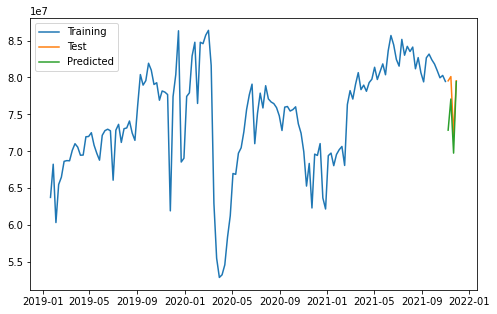

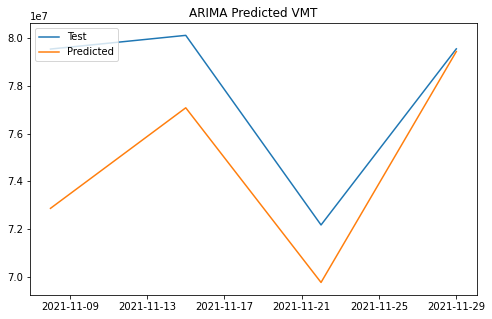

R2 Score: -0.3811960088562274
MAPE: 0.039165873516450324
MSE: 14909168782811.695
RMSE: 3861239.28069884


In [9]:
arima_pred = eval_ARIMA()

Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_311 (SimpleRNN)  (None, 9, 48)             2976      
                                                                 
 dropout_310 (Dropout)       (None, 9, 48)             0         
                                                                 
 simple_rnn_312 (SimpleRNN)  (None, 88)                12056     
                                                                 
 dropout_311 (Dropout)       (None, 88)                0         
                                                                 
 dense_129 (Dense)           (None, 1)                 89        
                                                                 
Total params: 15,121
Trainable params: 15,121
Non-trainable params: 0
_________________________________________________________________
None
(161, 13)
(140, 9, 13) (4, 9, 13) (4, 9, 13

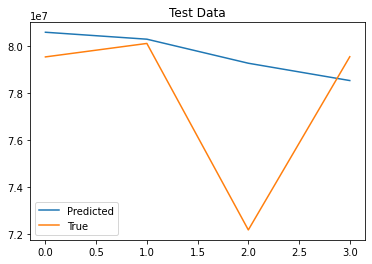

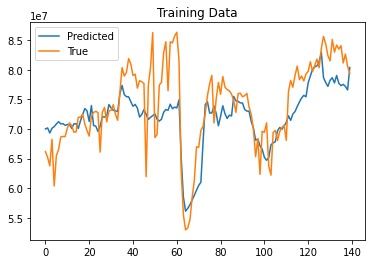

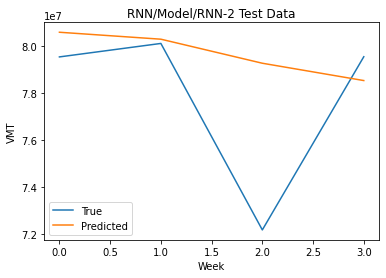

In [10]:
rnn_pred = load_eval_model_rnn('RNN/Model/RNN-2', 9, 'RNN/output/RNN-test.jpg')

Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_683 (LSTM)             (None, 2, 48)             11904     
                                                                 
 dropout_681 (Dropout)       (None, 2, 48)             0         
                                                                 
 lstm_684 (LSTM)             (None, 2, 48)             18624     
                                                                 
 dropout_682 (Dropout)       (None, 2, 48)             0         
                                                                 
 lstm_685 (LSTM)             (None, 92)                51888     
                                                                 
 dropout_683 (Dropout)       (None, 92)                0         
                                                                 
 dense_131 (Dense)           (None, 1)              

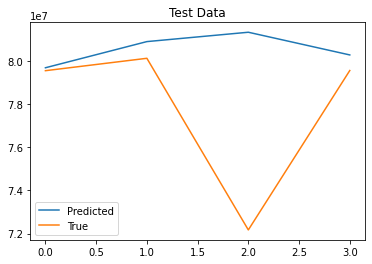

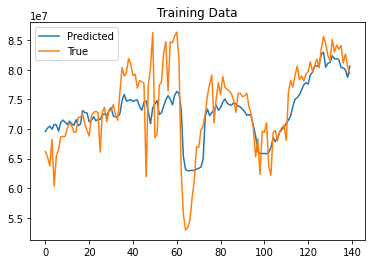

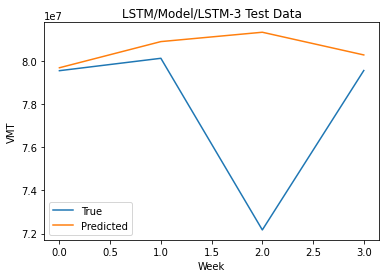

In [11]:
lstm_pred = load_eval_model_rnn('LSTM/Model/LSTM-3', 2, 'LSTM/output/LSTM-test.jpg')

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_69 (InputLayer)       [(None, 13, 7)]           0         
                                                                 
 tf.expand_dims_34 (TFOpLamb  (None, 13, 7, 1)         0         
 da)                                                             
                                                                 
 reshape_102 (Reshape)       (None, 13, 7)             0         
                                                                 
 fixed_adjacency_graph_convo  (None, 13, 10)           252       
 lution_68 (FixedAdjacencyGr                                     
 aphConvolution)                                                 
                                                                 
 fixed_adjacency_graph_convo  (None, 13, 24)           422       
 lution_69 (FixedAdjacencyGr                              

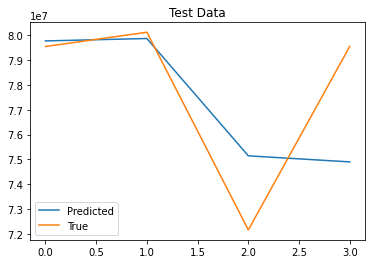

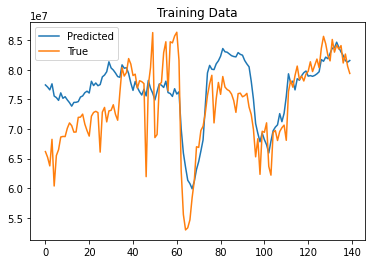

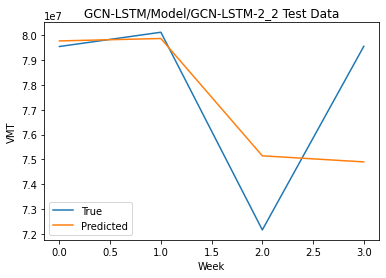

In [12]:
gcn_pred = load_eval_model_gcn('GCN-LSTM/Model/GCN-LSTM-2_2', 7, 'GCN-LSTM/output/GCN-LSTM-test.jpg')

In [13]:
saltlake_week = pd.read_csv('../Data/saltlake_week.csv')
data = saltlake_week[['Cases', 'VMT (Veh-Miles)', 'News Sentiment', 'Unemployment Rate', 'PRCP', 'SNWD',
                        'Percent_Fully_Vaccinated_5&Older', 'TAVG', 
                    'Stay at Home', 'Mask', 'School Opening', 'Health Emergency', 'Holiday']]

In [14]:
y = saltlake_week[['Day', 'VMT (Veh-Miles)']].iloc[53:209, :]
y.columns = ['Week', 'VMT']
y['Week'] = pd.to_datetime(y['Week'])
y.set_index('Week', inplace=True)
y.head()

,VMT
Week,
2019-01-07,66181817.1
2019-01-14,65217107.0
2019-01-21,63764156.8
2019-01-28,68255092.9
2019-02-04,60363403.4


In [15]:
y_scaler, y_scaled = utils.scale(y)
y_scaled = pd.DataFrame(y_scaled)
y_scaled.columns = ['VMT']
testY = y_scaled.iloc[148:, :]
testY.set_index(np.arange(1, 5), inplace=True)

In [16]:
testY_inv = pd.DataFrame(y_scaler.inverse_transform(testY), index=testY.index, columns=['VMT'])
testY_inv

,VMT
1,79542545.3
2,80116497.7
3,72167973.1
4,79550158.9


In [17]:
persistence_pred = pd.DataFrame(y_scaler.inverse_transform(y_scaled.iloc[147:151]), index=testY_inv.index, columns=['Predicted VMT'])
arima_pred = pd.DataFrame(arima_pred, index=testY.index, columns=['ARIMA Predicted VMT'])
rnn_pred = pd.DataFrame(rnn_pred, index=testY.index, columns=['RNN Predicted VMT'])
lstm_pred = pd.DataFrame(lstm_pred, index=testY.index, columns=['LSTM Predicted VMT'])
gcn_pred = pd.DataFrame(gcn_pred, index=testY.index, columns=['GCN-LSTM Predicted VMT'])

In [18]:
def plot_figs(true, persistence, arima, rnn, lstm, gcn, path):
    mpl.rc('font', family='Times New Roman', size=14)
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    
    fig = plt.figure(figsize=(24, 21))

    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    mpl.rc('font', size=18)
    ax1.set_title('ARIMA Predicted VMT')
    ax1.set_xlabel('Week')
    ax1.set_ylabel('VMT (Tens of Millions)')
    mpl.rc('font', size=14)
    ax1.plot(arima_pred, label='ARIMA', color='tab:blue', linewidth=3)
    ax1.plot(persistence, label='Persistence', color='tab:orange', linewidth=3)
    ax1.plot(true, label='True', color='tab:green', linewidth=3)
    ax1.legend()
    ax1.set_xticks(np.arange(1, 5))
    ax1.set_ylim([6*10**7, 8.5*10**7])
    
    mpl.rc('font', size=18)
    ax2.set_title('RNN Predicted VMT')
    mpl.rc('font', size=14)
    ax2.plot(rnn_pred, label='RNN', color='tab:blue', linewidth=3)
    ax2.plot(persistence, label='Persistence', color='tab:orange', linewidth=3)
    ax2.plot(true, label='True', color='tab:green', linewidth=3)
    ax2.legend()
    ax2.set_xlabel('Week')
    ax2.set_ylabel('VMT (Tens of Millions)')
    ax2.set_xticks(np.arange(1, 5))
    ax2.set_ylim([6*10**7, 8.5*10**7])
    
    mpl.rc('font', size=18)
    ax3.set_title('LSTM Predicted VMT')
    mpl.rc('font', size=14)
    ax3.plot(lstm_pred, label='LSTM', color='tab:blue', linewidth=3)
    ax3.plot(persistence, label='Persistence', color='tab:orange', linewidth=3)
    ax3.plot(true, label='True', color='tab:green', linewidth=3)
    ax3.legend()
    ax3.set_xlabel('Week')
    ax3.set_ylabel('VMT (Tens of Millions)')
    ax3.set_xticks(np.arange(1, 5))
    ax3.set_ylim([6*10**7, 8.5*10**7])
    
    mpl.rc('font', size=18)
    ax4.set_title('GCN-LSTM Predicted VMT')
    mpl.rc('font', size=14)
    ax4.plot(gcn, label='GCN_LSTM', color='tab:blue', linewidth=3)
    ax4.plot(persistence, label='Persistence', color='tab:orange', linewidth=3)
    ax4.plot(true, label='True', color='tab:green', linewidth=3)
    ax4.legend()
    ax4.set_xlabel('Week')
    ax4.set_ylabel('VMT (Tens of Millions)')
    ax4.set_xticks(np.arange(1, 5))
    ax4.set_ylim([6*10**7, 8.5*10**7])
    
    plt.savefig(path)

    plt.show()

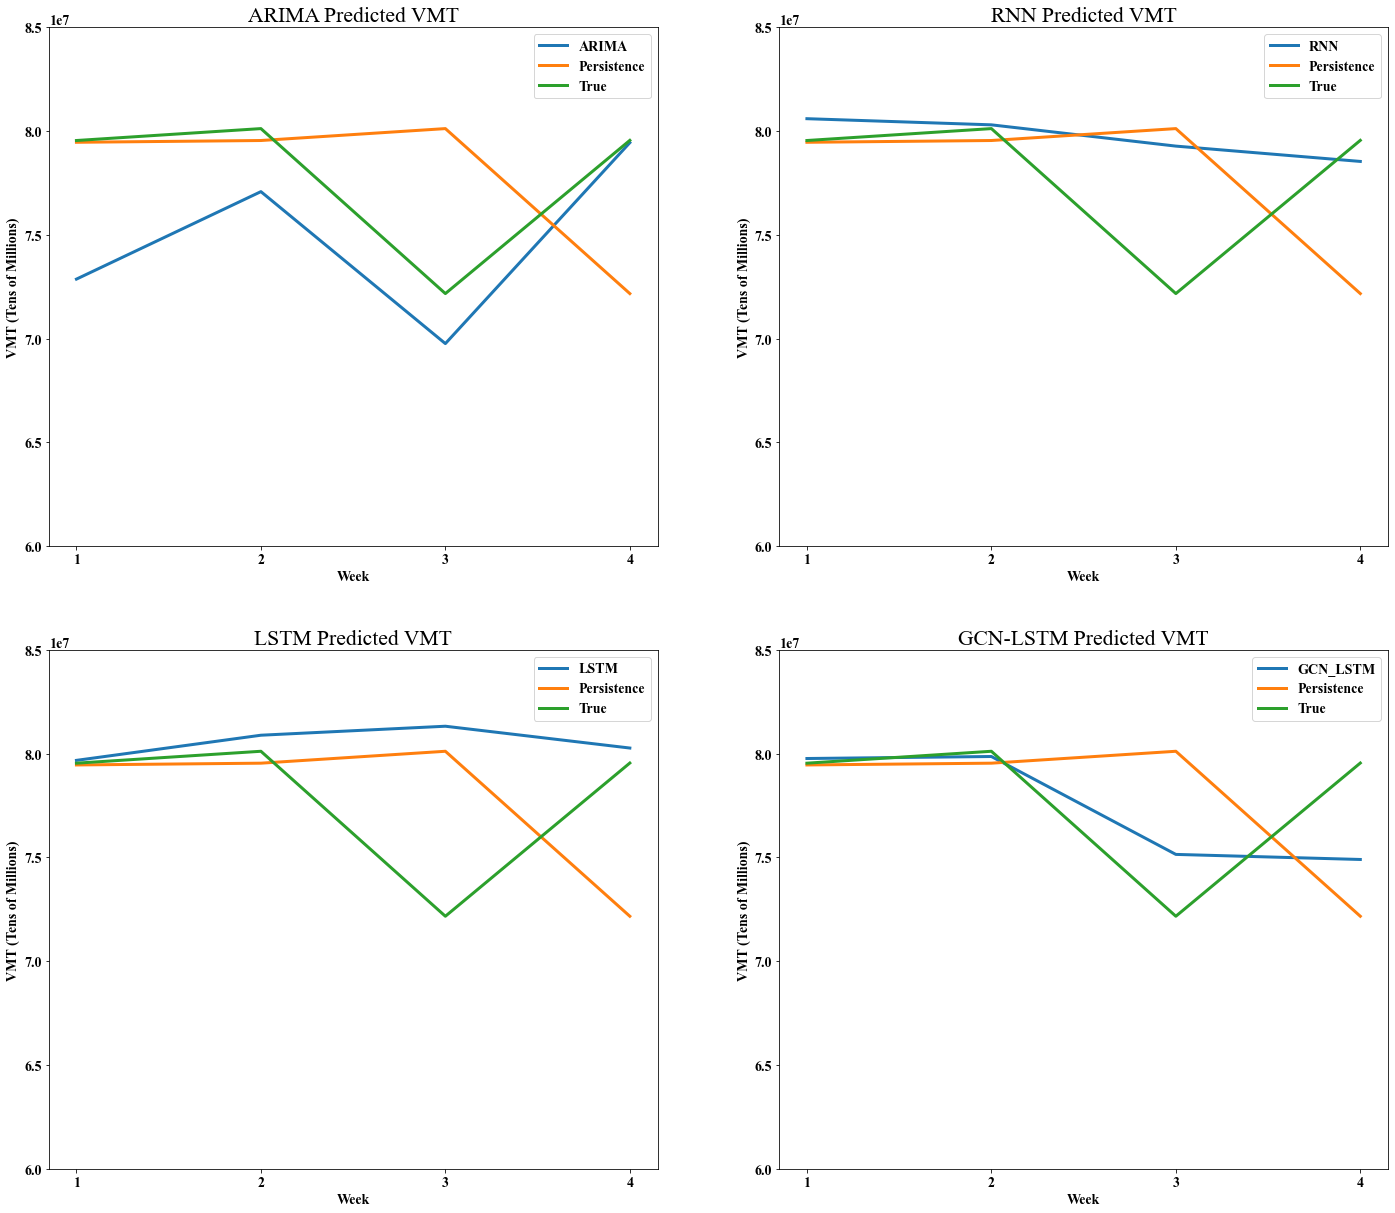

In [19]:
plot_figs(testY_inv, persistence_pred, arima_pred, rnn_pred, lstm_pred, gcn_pred, 'figures/Predicted VMT.jpg')

In [20]:
models = [arima_pred, rnn_pred, lstm_pred, gcn_pred]
names = ['ARIMA', 'RNN', 'LSTM', 'GCN-LSTM']

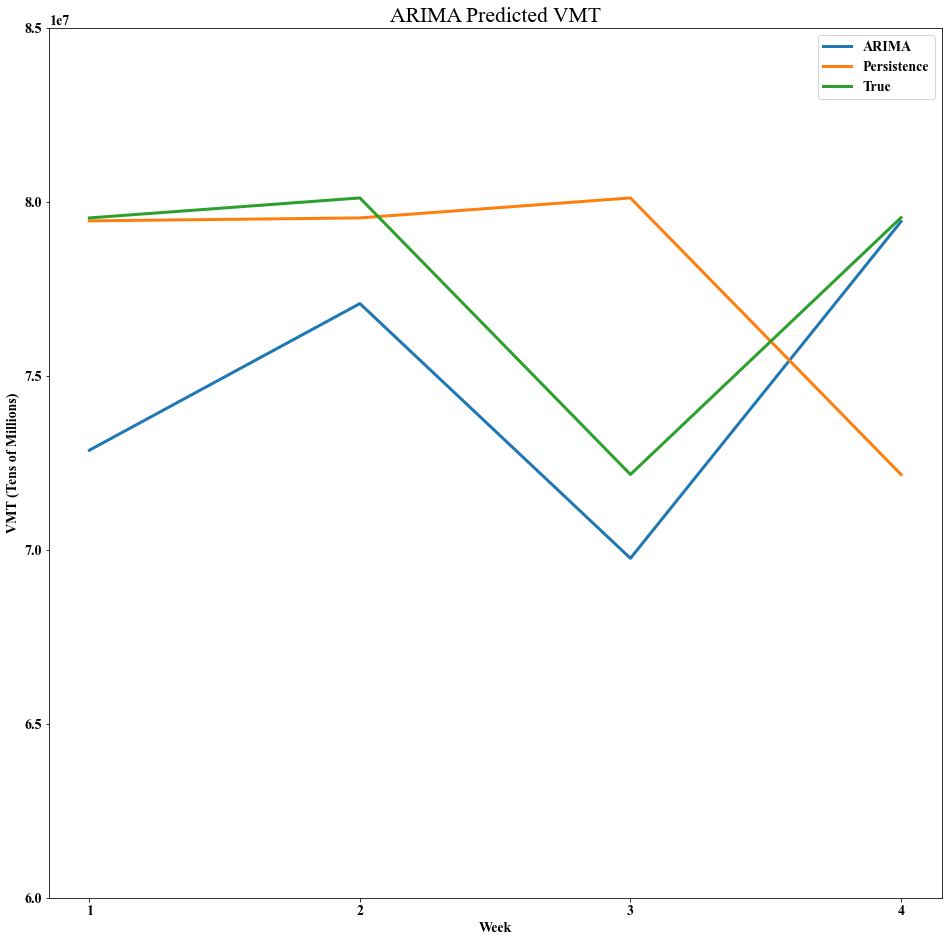

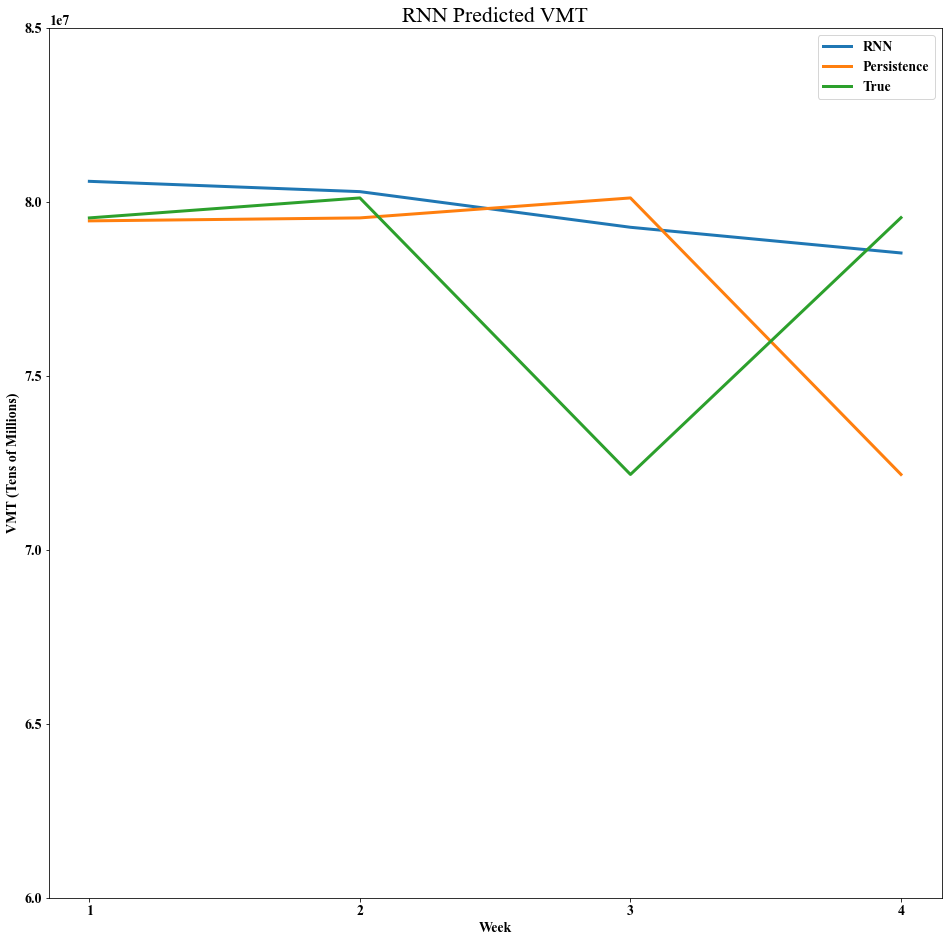

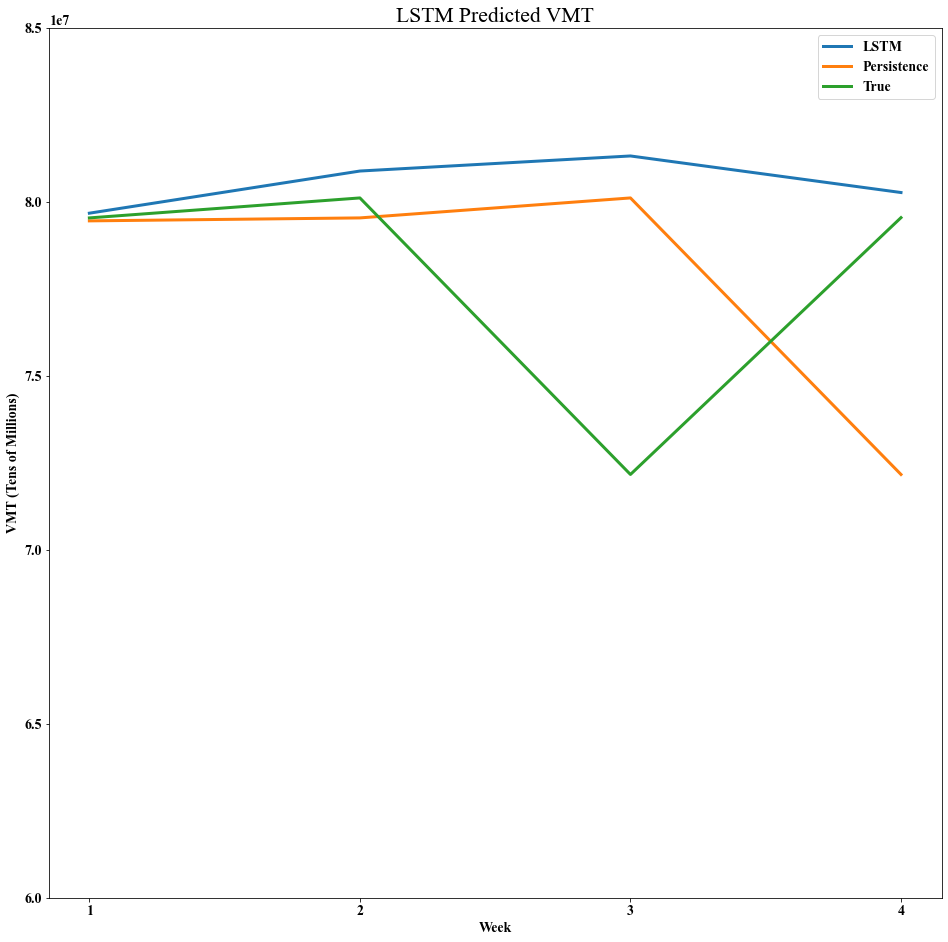

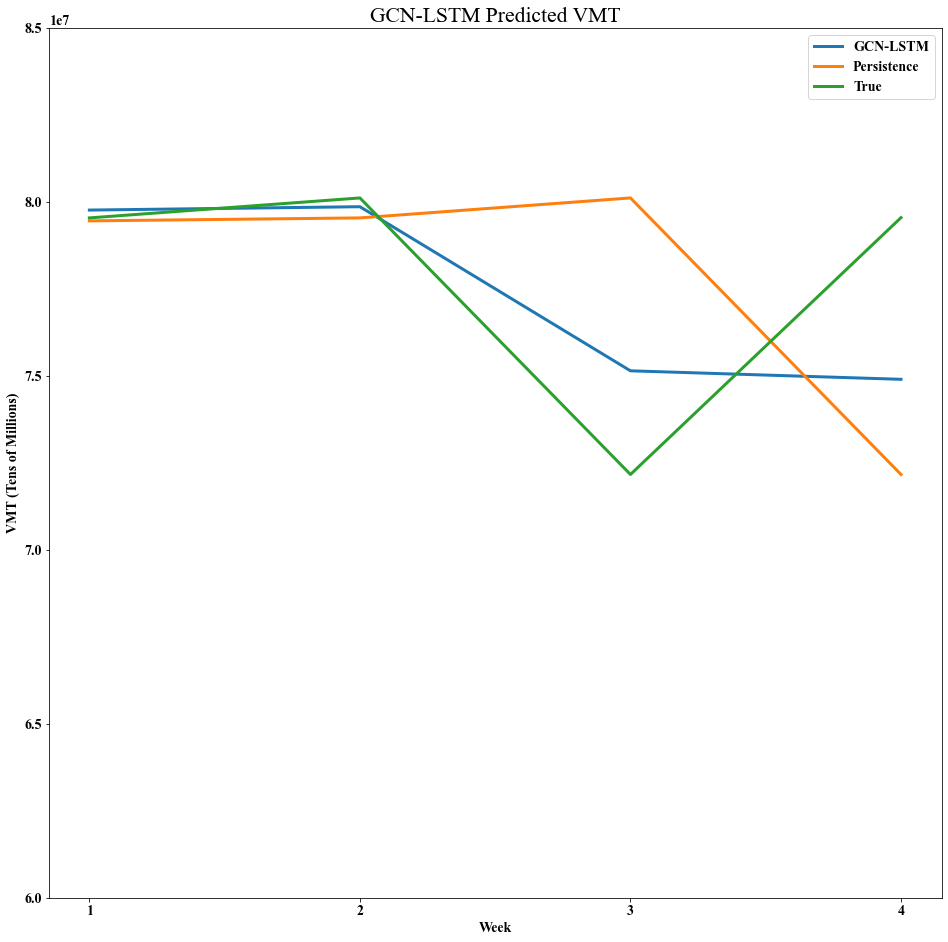

In [21]:
mpl.rc('font', family='Times New Roman', size=14)

for i in range(4):
    pred = models[i]
    pred.index = [i for i in range(1, 5)]
    pers = persistence_pred.copy()
    pers.index = [i for i in range(1, 5)]
    true = testY_inv
    true.index = [i for i in range(1, 5)]
    
    fig, ax = plt.subplots(figsize=(16,16))
    
    ax.set_xlabel('Week')
    ax.set_ylabel('VMT (Tens of Millions)')
    
    mpl.rc('font', size=18)
    ax.set_title('{} Predicted VMT'.format(names[i]))
    
    mpl.rc('font', size=14)
    ax.plot(pred, label=names[i], color='tab:blue', linewidth=3)
    ax.plot(pers, label='Persistence', color='tab:orange', linewidth=3)
    ax.plot(true, label='True', color='tab:green', linewidth=3)
    ax.legend()
    
    ax.set_xticks(np.arange(1, 5))
    ax.set_ylim([6*10**7, 8.5*10**7])
    
    plt.savefig('figures/{} Predictions.jpg'.format(names[i]))